## TPN°6 

In [28]:
#implementacion de un filtro fir en punto flotante 

## actividad N°1 

In [1]:
import numpy as np
import matplotlib.pyplot as pl
#%matplotlib qt5
from tool._fixedInt import *

In [2]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Respuesta al impulso del pulso de caida cosenoidal """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud, 
                       float(Tbaud)/oversampling) #limitacion de la respuesta al impulso

    y_vect = [] 
    #generacion del conseno realsado
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/    
                                        (1-(4.0*beta*beta*t*t/
                                            (Tbaud*Tbaud)))))

    y_vect = np.array(y_vect)

    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)

In [3]:
#generacion de respuesta en frecuencia
def resp_freq(filt, Ts, Nfreqs):
    """Computo de la respuesta en frecuencia de cualquier filtro FIR"""
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

In [4]:
def eyediagram(data, n, offset, period):
    span     = 2*n
    segments = int(len(data)/span)
    xmax     = (n-1)*period
    xmin     = -(n-1)*period
    x        = list(np.arange(-n,n,)*period)
    xoff     = offset

    pl.figure()
    for i in range(0,segments-1):
        pl.plot(x, data[(i*span+xoff):((i+1)*span+xoff)],'b')       
    pl.grid(True)
    pl.xlim(xmin, xmax)
    pl.show()

In [3]:
#filtro fir sin nunguna optimizacion
def fir1(x,h):
    r = np.zeros(len(h)-1) #registro
    y = np.zeros(len(x))   #salida
    for i in range(len(x)):
        y[i] = x[i] * h[i-i]       #multiplicacion el simbolo de entrada con h[0]
        for e in range(len(h)-1):
            y[i] += r[e] * h[e+1]  #voy multiplicando guardados en el registro
        r = np.roll(r,1)           #desplazo el simbolo dentro del registro
        r[0] = x[i]                #guardo el ultimo simbolo que ingreso
    return y

In [6]:
## filtro fir polifasico para cualquier cantidad de fases
#decompongo el filtro en base a ov, si ov = 4 ==> 4 fases (4 subfiltros)
#por cada simbolo tengo os(4) salidas dada por los sub filtros, por lo que la salida es una convinacion de estas 
def fir_polifasico(symbols,os):
    y_poli=np.zeros(len(symbols)*int(os))
    for i in range(int(os)):   
        h_sub = h[i::int(os)]       #obtengo los coeficientes para cada sub filtro 
        y_aux = fir1(symbols,h_sub) #obtengo las salidas por cada filtro
        y_poli[i::int(os)]=y_aux    #convino las salidad de los filtros para generar la salidad real
    return y_poli
#recordatorio: en verilog se pueden multiplexar los coeficientes por medio de un contador de 2bit a la frecuencia del SR para los distinto coeficientes

In [7]:
##implementacion de fir polifasico serie para 4 fases
def fir_polifasico1(symbols):
    h0=h[0::int(os)]
    h1=h[1::int(os)]
    h2=h[2::int(os)]
    h3=h[3::int(os)]
    r=np.zeros(len(h0)-1)
    y=[]
    x=symbols
    for i in range(0,len(x)):
        for e in range(int(os)):
            if(e==0):
                y.append(x[i]*h0[0]+np.dot(r,h0[1:]))
            if(e==1):
                y.append(x[i]*h1[0]+np.dot(r,h1[1:]))
            if(e==2):
                y.append(x[i]*h2[0]+np.dot(r,h2[1:]))
            if(e==3):
                y.append(x[i]*h3[0]+np.dot(r,h3[1:]))
        r=np.roll(r,1)
        r[0]=x[i]
    return y

In [11]:
## Parametros generales
Baud  = 1.0e9           # baudrate 
T     = (1.0/Baud)     # Periodo de baudio
Nsymb = 100             # Numero de simbolos
os    = 4               # Factor de sobre muestreo(oversampling), cantidad de muestras por periodo para representar el coseno 

## Parametros de la respuesta en frecuencia
Nfreqs = 256            # Cantidad de frecuencias

## Parametros del filtro de caida cosenoidal
beta   = [0.0,0.5,1.0]  # Roll-Off
Nbauds = 6.0           # Cantidad de baudios del filtro(largo de la respuesta al impulso)
## Parametros funcionales
Ts = T/os               # Frecuencia de muestreo 

cantidad de coeficientes:  24


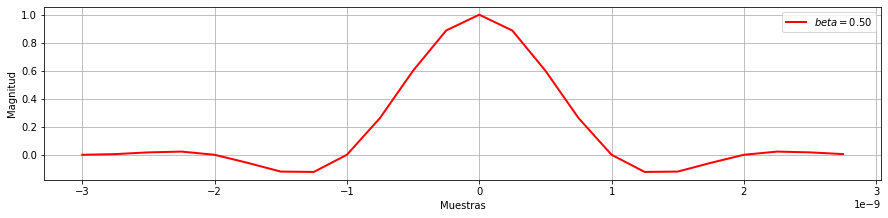

In [12]:
#respuesta al impulso
(t,h) = rcosine(beta[1], T,os,Nbauds,Norm=False)
pl.figure(figsize=[15,7])
pl.subplot(2,1,1)
pl.plot(t,h,'r',linewidth=2.0,label=r'$beta=%2.2f$'%beta[1])
pl.grid(True)
pl.legend()
pl.show
pl.xlabel('Muestras')
pl.ylabel('Magnitud')
print('cantidad de coeficientes: ', len(h)) #os*Nbaud

Text(0, 0.5, 'Magnitud [dB]')

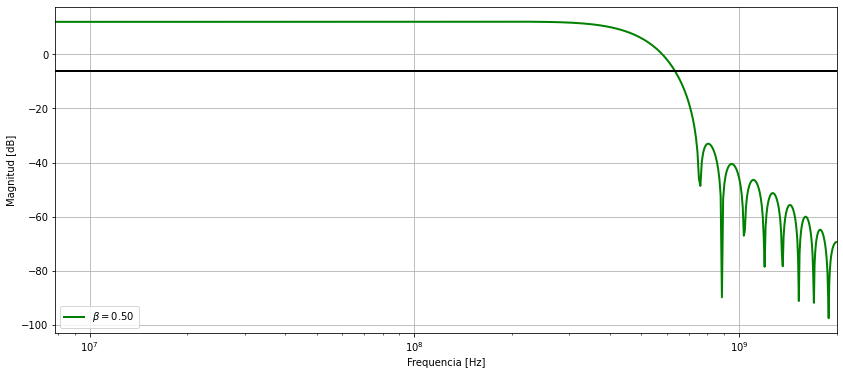

In [35]:
##respuesta en frecuencia
[H,A,F] = resp_freq(h, Ts, Nfreqs)
pl.figure(figsize=[14,6])
pl.semilogx(F, 20*np.log10(H),'g', linewidth=2.0, label=r'$\beta=%2.2f$'%beta[1])
pl.legend(loc=3)
pl.axhline(y=20*np.log10(0.5),color='k',linewidth=2.0)
pl.grid(True)
pl.xlim(F[1],F[len(F)-1])
pl.xlabel('Frequencia [Hz]')
pl.ylabel('Magnitud [dB]')
#se ve un ancho de banda entre 60**8 y 70**8

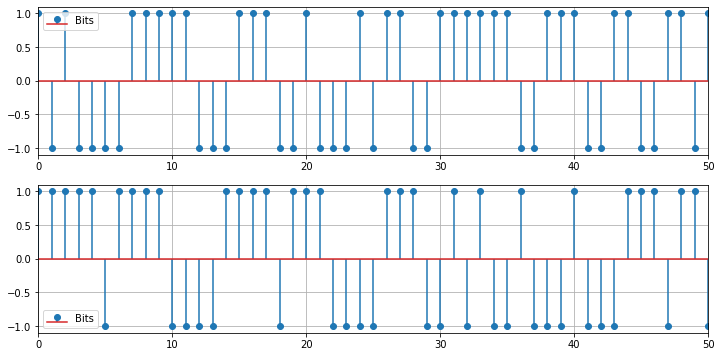

In [14]:
I = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
Q = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
I_os= np.zeros(os*Nsymb); I_os[0:len(I_os):int(os)] = I
Q_os= np.zeros(os*Nsymb); Q_os[0:len(Q_os):int(os)] = Q

pl.figure(figsize=[12,6])
pl.subplot(2,1,1)
pl.stem(I,label='Bits',use_line_collection=True)
pl.xlim(0,50)
pl.grid(True)
pl.legend()

pl.subplot(2,1,2)
pl.stem(Q,label='Bits',use_line_collection=True)
pl.xlim(0,50)
pl.grid(True)
pl.legend()

(0.0, 30.0)

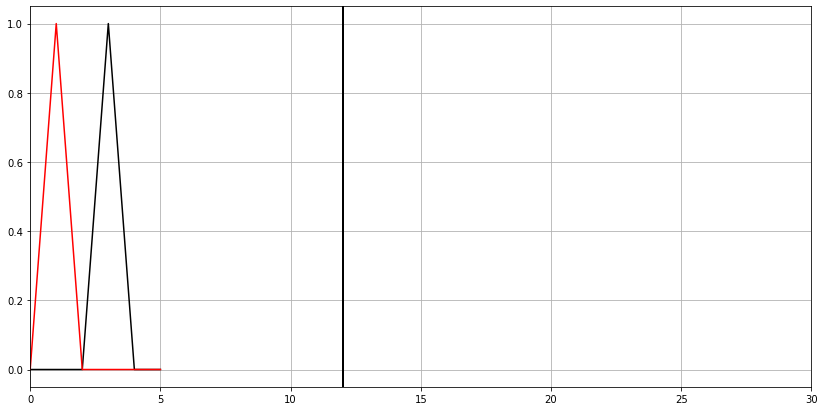

In [10]:
#latencia introducida por el filtro fir
xx=np.zeros(len(h))
xx[0]=1

y=fir1(xx,h)
pl.figure(figsize=[14,7])
pl.plot(y,'k')
pl.axvline(x=12,color='k',linewidth=2.0)

y_conv= np.convolve(h,xx,'same')
pl.plot(y_conv,'r')
pl.grid(True)
pl.xlim(0,30)

##obtenemos una latencia de (os*(Nbaud/2)) = 3*4 = 12

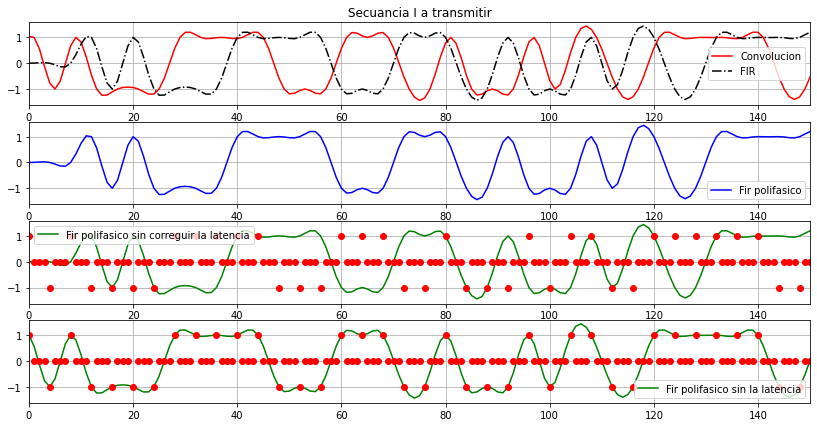

In [15]:
#comparaciones
y_conv= np.convolve(h,I_os,'same')
y_I=fir1(I_os,h)
y_Q=fir1(Q_os,h)
y_poli_I= fir_polifasico(I,os)
y_poli_Q=fir_polifasico(Q,os)

##para correguir latencia agregamos cero al final de la secuencia a transmitir y no perder simbolos
#correccion=(os*Nbauds)/2, para el caso de fir1
#y para el polofasico con solo agregar ceros por cada fase es suficiente para correguir la latencia

aux = np.zeros(os-1)           #cantidad de ceros a agregar para la trasmicion
I1 = np.concatenate((I,aux))
Q1 = np.concatenate((Q,aux))
##secuencia a trasmitir correguida
y_poli_I1 = fir_polifasico1(I1)
y_poli_Q1 = fir_polifasico1(Q1)

pl.figure(figsize=[14,7])
pl.subplot(4,1,1)
pl.plot(y_conv,'r-',label='Convolucion')
pl.plot(y_I,'k-.',label='FIR')
pl.grid(True)
pl.legend()
pl.xlim(0,150)
pl.title("Secuancia I a transmitir")

pl.subplot(4,1,2)
pl.plot(y_poli_I,'b',label='Fir polifasico')
pl.grid(True)
pl.legend()
pl.xlim(0,150)

pl.subplot(4,1,3)
pl.plot(y_poli_I,'g',label='Fir polifasico sin correguir la latencia')
pl.plot(I_os,'or')
pl.grid(True)
pl.legend(loc=2)
pl.xlim(0,150)

pl.subplot(4,1,4)
pl.plot(y_poli_I1[12:],'g',label='Fir polifasico sin la latencia')
pl.plot(I_os,'or')
pl.grid(True)
pl.legend(loc=4)
pl.xlim(0,150)

pl.show()
#como vemos se observa la latencia y la salida de filtro fir en su arquitectura simple es igual a la salida del fir polifasico
#se obseva que al tener una latencia se pierden los ultimos simbolos en la trasmicion

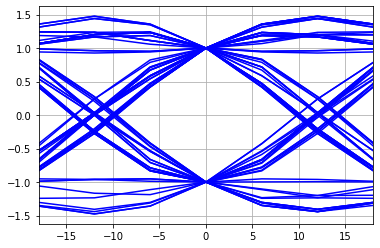

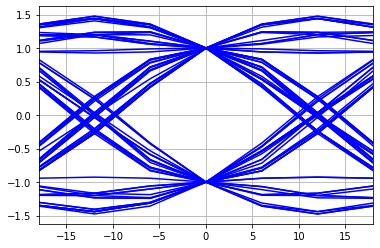

In [14]:
#diagrama de ojo
eyediagram(y_poli_I1[100:len(y_poli_I1)-100],os,8,Nbauds)
eyediagram(y_poli_Q1[100:len(y_poli_Q1)-100],os,8,Nbauds)
pl.show()
#se observan las 4 fases y siendo la 3 fase la mas problematica para el receptor

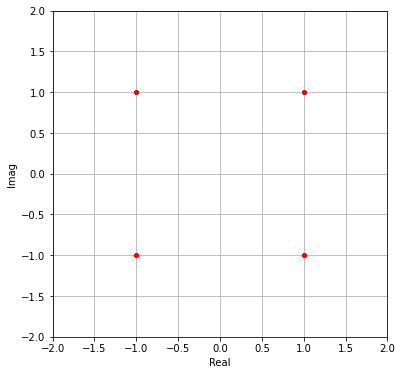

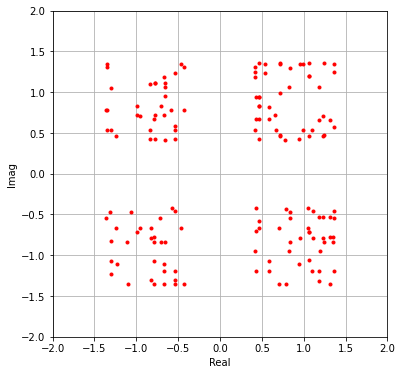

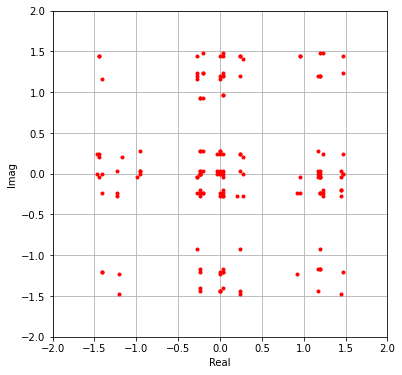

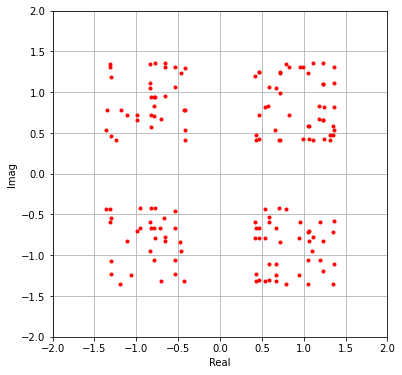

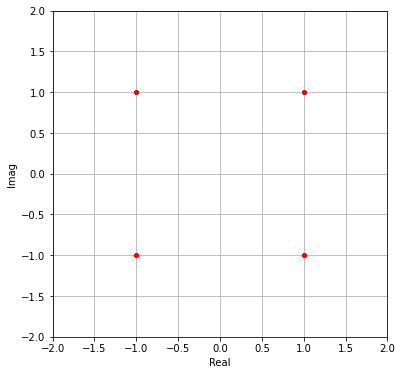

In [15]:
#diagrama de constelaciones  
for offset in range(5):
    pl.figure(figsize=[6,6])
    pl.plot(y_poli_I1[100+offset:len(y_poli_I1)-(100-offset):int(os)],
            y_poli_Q1[100+offset:len(y_poli_Q1)-(100-offset):int(os)],
            '.r',linewidth=2.0)
    pl.xlim(-2,2)
    pl.ylim(-2,2)
    pl.grid(True)
    pl.xlabel('Real')
    pl.ylabel('Imag')
#optimo en cero y cada 4, como vimos en le diagrama de fase la 3 fase es la que mas complica al receptor para la toma de decision

## BER

[8.951031857289794e-34, -1.0723256333694665e-16, 1.1085881883258743e-15, 0.9999999999999989, -1.0000000000000004, 1.000000000000001, -1.000000000000003, -0.9999999999999987, -0.9999999999999998, -0.9999999999999978, 1.000000000000002, 0.9999999999999987, 0.9999999999999998, 0.9999999999999998, 0.9999999999999978, -1.000000000000002, -0.9999999999999988, -0.9999999999999978, 1.000000000000002, 0.9999999999999988, 0.9999999999999978, -1.0000000000000022, -0.9999999999999967, 1.0, -1.000000000000003, -0.9999999999999988, -0.9999999999999978, 1.0, -1.000000000000001, 1.000000000000003, 0.9999999999999968, -1.0000000000000022, -0.9999999999999968, 1.000000000000002, 0.9999999999999987, 0.9999999999999998, 0.9999999999999998, 0.9999999999999998, 0.9999999999999978, -1.0000000000000022, -0.9999999999999968, 1.000000000000002, 0.9999999999999988, 0.9999999999999978, -1.0000000000000022, -0.9999999999999968, 1.0000000000000022, 0.9999999999999968, -1.0000000000000022, -0.9999999999999968, 1.000

ValueError: x and y must have same first dimension, but have shapes (103,) and (100,)

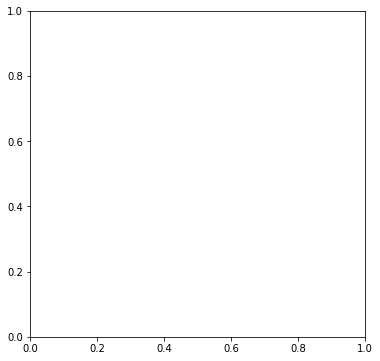

In [17]:
##armarlo como funcion ,TERMINAR!!!
latencia=12
offset=0
bit_de_error=0
I_recivido=y_poli_I1[(offset+latencia)::int(os)]
Q_recivido=y_poli_Q1[(offset+latencia)::int(os)]
print(I_recivido)
for i in range(len(I)):
    if(I[i]==1 and Q[i]==1):                    ##1 cuadrante 00
        if(I_recivido[i]<=0 or Q_recivido[i]<0):
            bit_de_error+=1
            #print('1 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(I[i]==1 and Q[i]==-1):                  #4 cuadrante 11
        if(I_recivido[i]<0 or Q_recivido[i]>=0):
            bit_de_error+=1
            #print('4 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(I[i]==-1 and Q[i]==1):                  #2 cuadrante 01
        if(I_recivido[i]>0 or Q_recivido[i]<=0):
            bit_de_error+=1
            #print('2 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(I[i]==-1 and Q[i]==-1):                 #3 cuadrante 10
        if(I_recivido[i]>=0 or Q_recivido[i]>0):
            bit_de_error+=1
            #print('3 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
print('cantidad de simbolos enviados  = {}'.format(len(I)))
print('cantidad de simbolos recividos =', len(I_recivido))
print('error:',bit_de_error)
print('BER:',(bit_de_error/len(I_recivido))*100,'%')

pl.figure(figsize=[6,6])
pl.plot(I_recivido,Q_recivido,'.r',linewidth=2.0)
pl.xlim(-2,2)
pl.ylim(-2,2)
pl.grid(True)
pl.xlabel('Real')
pl.ylabel('Imag')
# con una fase de 3 lo que sucede es que estoy mas proximo del simbolo que sigue por eso me da mas error pero en el diagrama de constalaciones se ve que 
# recupera bien pero el simbolo siguiente